In [2]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import geopandas as gpd

from shapely.geometry import Point
from shapely import wkt
import contextily as ctx
from sklearn.neighbors import KernelDensity

**What are the transportation barriers faced by community college students in SF East Bay community colleges and how do they vary by demographic group?**

**Racial Demographic Data**

Previously in SurveyDataAnalysis:


In [3]:
survey = pd.read_csv('Qualtrics_May 27, 2025_labels.csv')
survey = survey.iloc[1:].reset_index(drop=True)

C:\Users\jcoll\AppData\Local\Temp\ipykernel_12736\3791435903.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q13, order=reason_counts_q13['Reason'], palette='pastel')


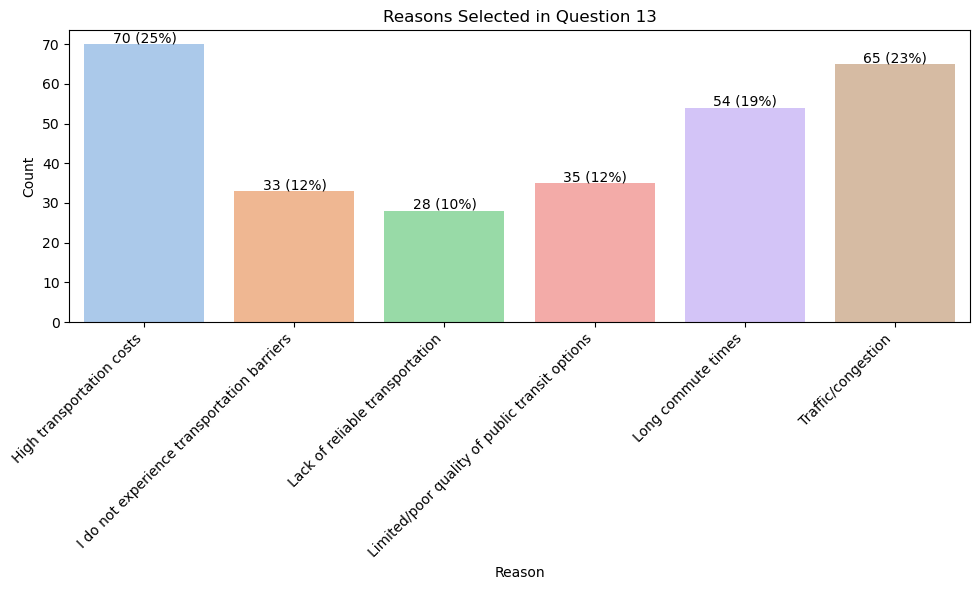

In [4]:
# Question 13 : Do you experience any of these transportation barriers? (Check all that apply)

# Split, explode, and clean up the responses
reasons_series_q13 = survey['Question 13'].dropna().str.split(',').explode().str.strip()

# Count occurrences of each response
reason_counts_q13 = reasons_series_q13.value_counts().reset_index()
reason_counts_q13.columns = ['Reason', 'Count']

# (Optional) Standardize 'Other: (please describe)' to 'Other'
reason_counts_q13['Reason'] = reason_counts_q13['Reason'].replace('Other: (please describe)', 'Other')
reason_counts_q13 = reason_counts_q13.groupby('Reason', as_index=False)['Count'].sum()

# Round counts to nearest whole number (for display)
reason_counts_q13['Count'] = reason_counts_q13['Count'].round().astype(int)

# Graph

total_reasons_q13 = reason_counts_q13['Count'].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Reason', y='Count', data=reason_counts_q13, order=reason_counts_q13['Reason'], palette='pastel')

# Add count and percentage labels on top of each bar, both as integers
for p in ax.patches:
    height = int(round(p.get_height()))
    percentage = int(round((height / total_reasons_q13) * 100))
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height} ({percentage}%)',
        ha='center'
    )

plt.title('Reasons Selected in Question 13')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


First lets look at trends with **Race/Ethnicity** (Question 3)

In [6]:
#Question 3: Race/Ethnicity
print(survey["Question 3"], survey["Question 3_7_TEXT"])

# Step 1: Replace "Prefer to self describe:" with custom text
mask = survey["Question 3"] == "Prefer to Self Describe:"
survey.loc[mask, "Question 3"] = survey.loc[mask, "Question 3_7_TEXT"]
survey.loc[survey["Question 3"].str.contains(",", na=False), "Question 3"] = "Two or More"

survey['Question 3'] = survey['Question 3'].replace({
    'Ethiopia ': 'African',
    'North african': 'African',
    "I’m a mix between a Mexican and American ": 'Hispanic, Latine, and Chicano',
    'Chicano ': 'Hispanic, Latine, and Chicano',
    'Hispanic or Latine': 'Hispanic, Latine, and Chicano',
    'Latin American indigenous': 'Two or More'
})

survey['Question 3'].unique()

races = survey['Question 3'].unique().tolist()
# Choose a Seaborn palette and generate enough distinct colors
race_colors = sns.color_palette("tab10", n_colors=len(races))  # You can also use "Set2", "Paired", etc.

# Map each race to a color
race_palette = dict(zip(races, race_colors))

survey['Question 3'].unique()

0                          Asian,White or Caucasian
1      Black or African American,Hispanic or Latine
2      Black or African American,Hispanic or Latine
3                                             Asian
4                         Black or African American
                           ...                     
161                              Hispanic or Latine
162                       Black or African American
163                                           Asian
164                        Prefer to Self Describe:
165                            Prefer not to Answer
Name: Question 3, Length: 166, dtype: object 0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
           ...      
161              NaN
162              NaN
163              NaN
164    North african
165              NaN
Name: Question 3_7_TEXT, Length: 166, dtype: object


array(['Two or More', 'Asian', 'Black or African American',
       'Hispanic, Latine, and Chicano', 'African', nan,
       'White or Caucasian', 'Prefer not to Answer',
       'American Indian or Alaska Native'], dtype=object)

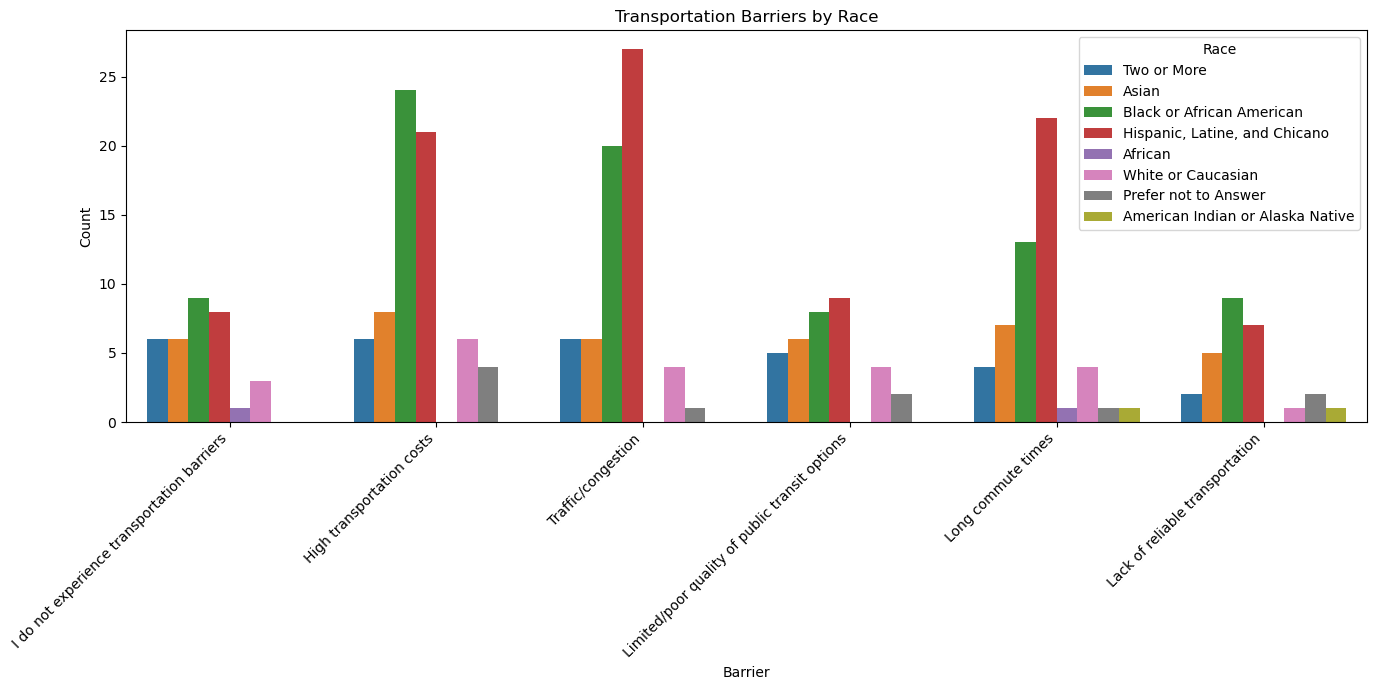

In [ ]:


# Filter out rows with missing 'Question 3' or 'Question 13'
survey_filtered = survey.dropna(subset=['Question 3', 'Question 13'])

# Step 1: Prepare a long-form DataFrame with columns: Race, Reason, Count
data = []

for race in races:
    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    reasons_series = df_race['Question 13'].str.split(',').explode().str.strip()
    reasons_series = reasons_series.replace('Other: (please describe)', 'Other')
    reason_counts = reasons_series.value_counts().reset_index()
    reason_counts.columns = ['Reason', 'Count']
    reason_counts['Race'] = race
    data.append(reason_counts)

long_df = pd.concat(data)



# Step 2: Plot using seaborn
plt.figure(figsize=(14, 7))
sns.barplot(data=long_df, x='Reason', y='Count', hue='Race', palette=race_palette)

plt.title('Transportation Barriers by Race')
plt.xlabel('Barrier')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Race')
plt.show()


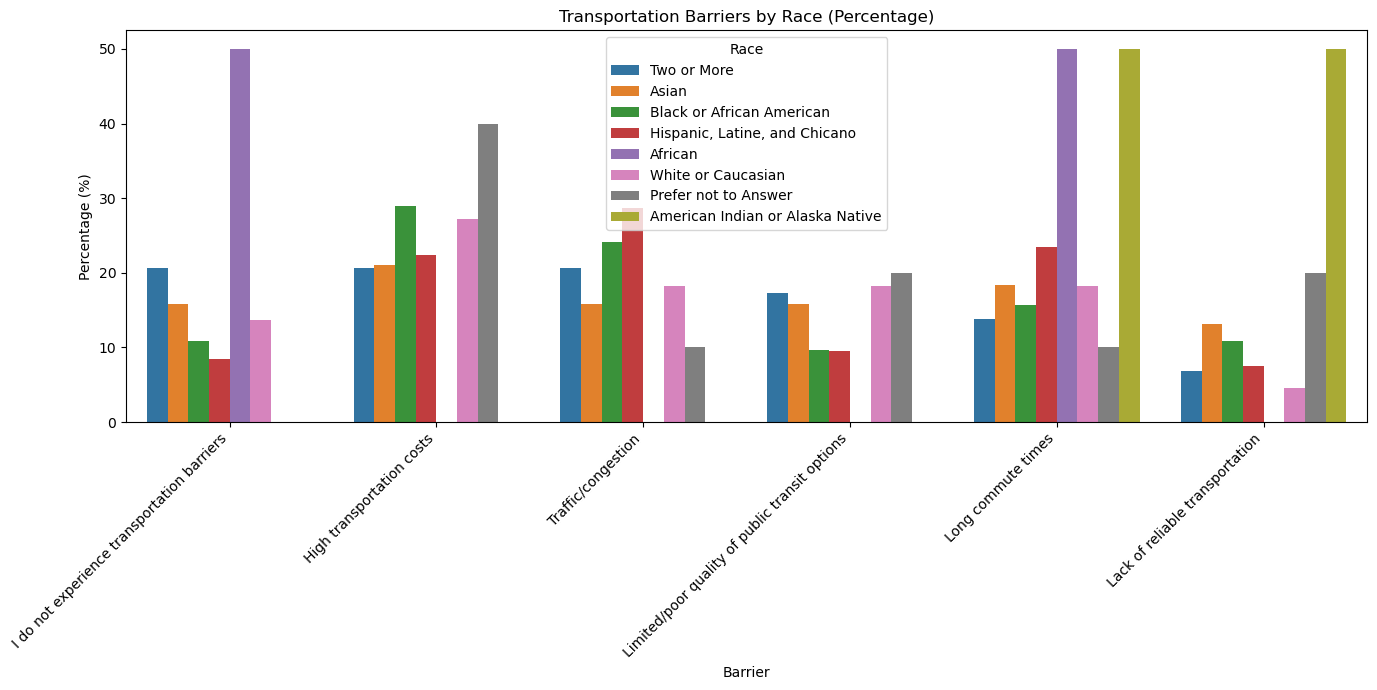

In [ ]:
# Filter out rows with missing 'Question 3' or 'Question 13'
survey_filtered = survey.dropna(subset=['Question 3', 'Question 13'])

# Get unique races
races = survey_filtered['Question 3'].unique()

# Prepare a long-form DataFrame with columns: Race, Reason, Percentage
data = []

for race in races:
    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    reasons_series = df_race['Question 13'].str.split(',').explode().str.strip()
    reasons_series = reasons_series.replace('Other: (please describe)', 'Other')
    reason_counts = reasons_series.value_counts().reset_index()
    reason_counts.columns = ['Reason', 'Count']
    reason_counts['Race'] = race
    total_count = reason_counts['Count'].sum()
    reason_counts['Percentage'] = (reason_counts['Count'] / total_count) * 100
    data.append(reason_counts)

long_df = pd.concat(data)

# Plot using seaborn
plt.figure(figsize=(14, 7))
sns.barplot(data=long_df, x='Reason', y='Percentage', hue='Race', palette=race_palette)

plt.title('Transportation Barriers by Race (Percentage)')
plt.xlabel('Barrier')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Race')
plt.show()


C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\4111190788.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=reason_counts, ax=ax, palette= 'Set1')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\4111190788.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=reason_counts, ax=ax, palette= 'Set1')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\4111190788.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=reason_counts, ax=ax, palette= 'Set1')
C:\U

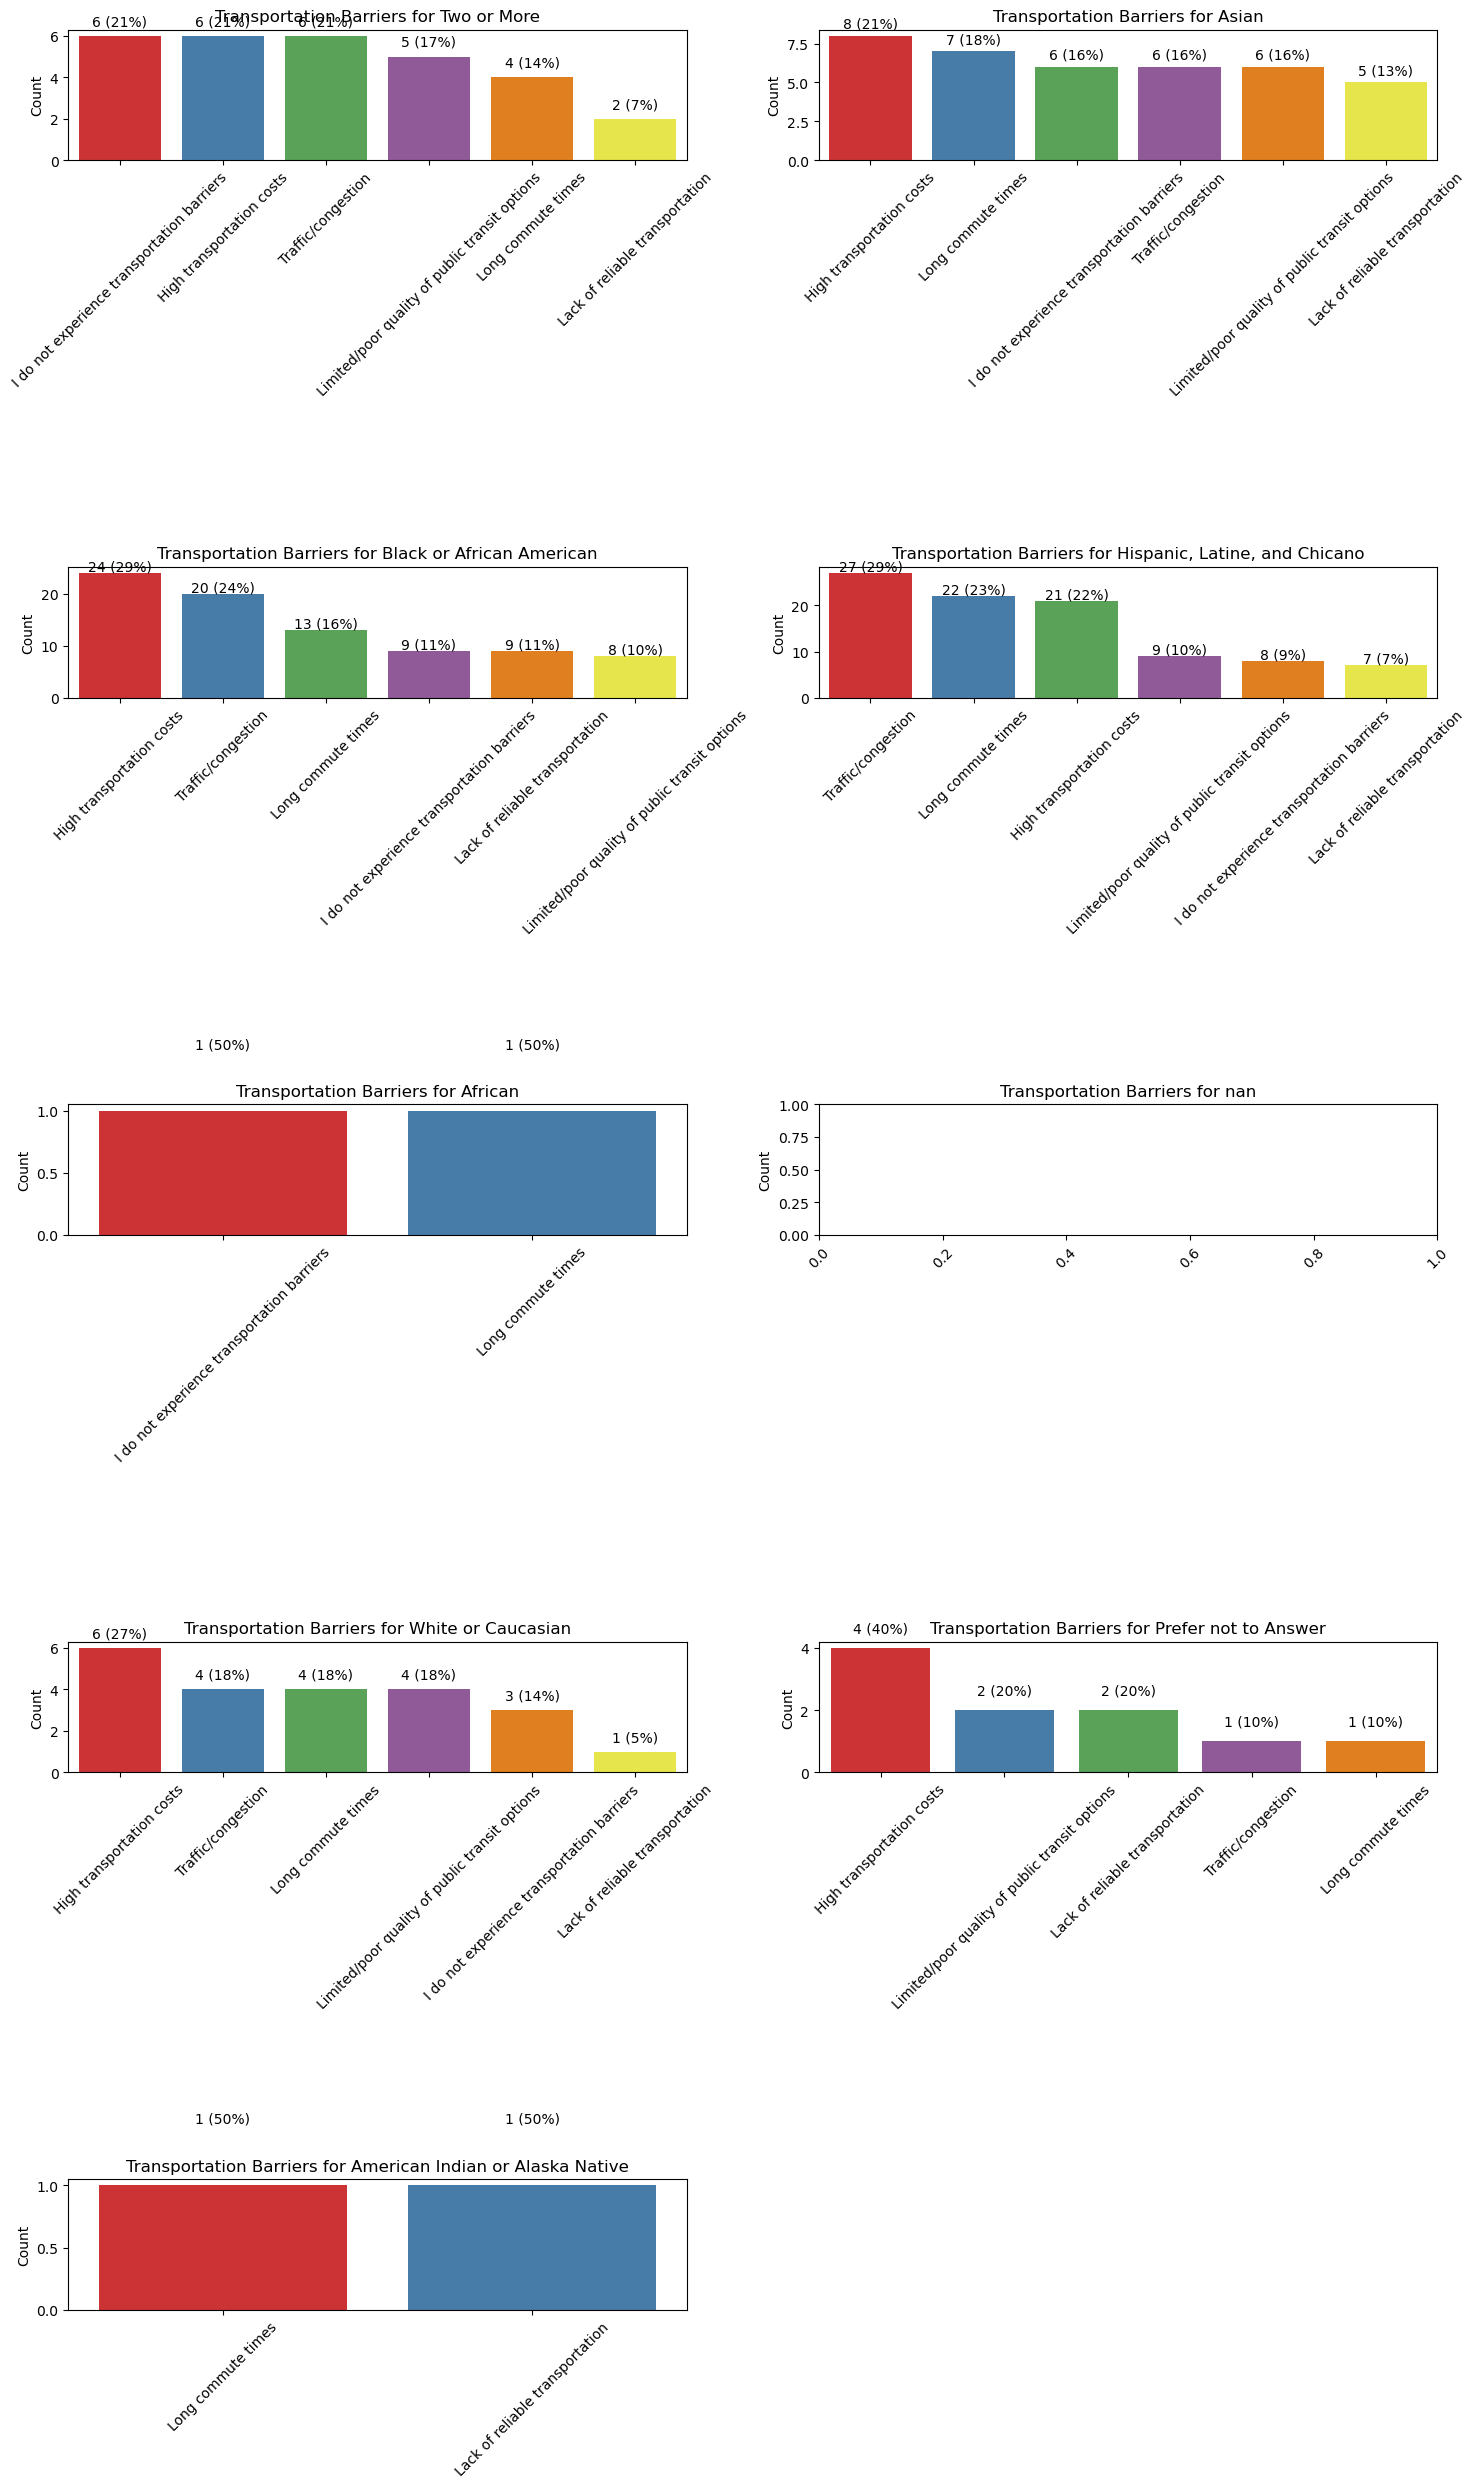

In [ ]:
import math

# Number of races
n_races = len(races)
n_cols = 2  # or 3, depending on how wide you want it
n_rows = math.ceil(n_races / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    reasons_series = df_race['Question 13'].str.split(',').explode().str.strip()
    reasons_series = reasons_series.replace('Other: (please describe)', 'Other')
    reason_counts = reasons_series.value_counts().reset_index()
    reason_counts.columns = ['Reason', 'Count']
    
    total = reason_counts['Count'].sum()

    sns.barplot(x='Reason', y='Count', data=reason_counts, ax=ax, palette= 'Set1')

    for p in ax.patches:
        height = int(round(p.get_height()))
        percent = int(round((height / total) * 100)) if total > 0 else 0
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{height} ({percent}%)',
            ha='center'
        )

    ax.set_title(f'Transportation Barriers for {race}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Prepare data: Split and explode barriers, standardize responses
survey_filtered = survey.dropna(subset=['Question 3', 'Question 13']).copy()
survey_filtered['Barrier'] = survey_filtered['Question 13'].str.split(',')
survey_filtered = survey_filtered.explode('Barrier')
survey_filtered['Barrier'] = survey_filtered['Barrier'].str.strip()
survey_filtered['Barrier'] = survey_filtered['Barrier'].replace('Other: (please describe)', 'Other')

# Create contingency table: Races (rows) vs. Barriers (columns)
contingency_table = pd.crosstab(
    survey_filtered['Question 3'], 
    survey_filtered['Barrier']
)

# Run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print(f"Chi-square statistic = {chi2:.2f}")
print(f"p-value = {p:.4f}")
print(f"Degrees of freedom = {dof}")

if p < 0.05:
    print("\n→ Significant association between race and barrier distribution (p < 0.05).")
    print("  Barrier reporting differs significantly across racial groups.")
else:
    print("\n→ No significant association between race and barrier distribution (p ≥ 0.05).")
    print("  Barrier reporting patterns are similar across racial groups.")


Chi-square statistic = 29.31
p-value = 0.7389
Degrees of freedom = 35

→ No significant association between race and barrier distribution (p ≥ 0.05).
  Barrier reporting patterns are similar across racial groups.


C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3346058217.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=reason_counts, palette=reason_palette, ax=ax)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3346058217.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=reason_counts, palette=reason_palette, ax=ax)
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3346058217.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=reason_counts, palette=reason

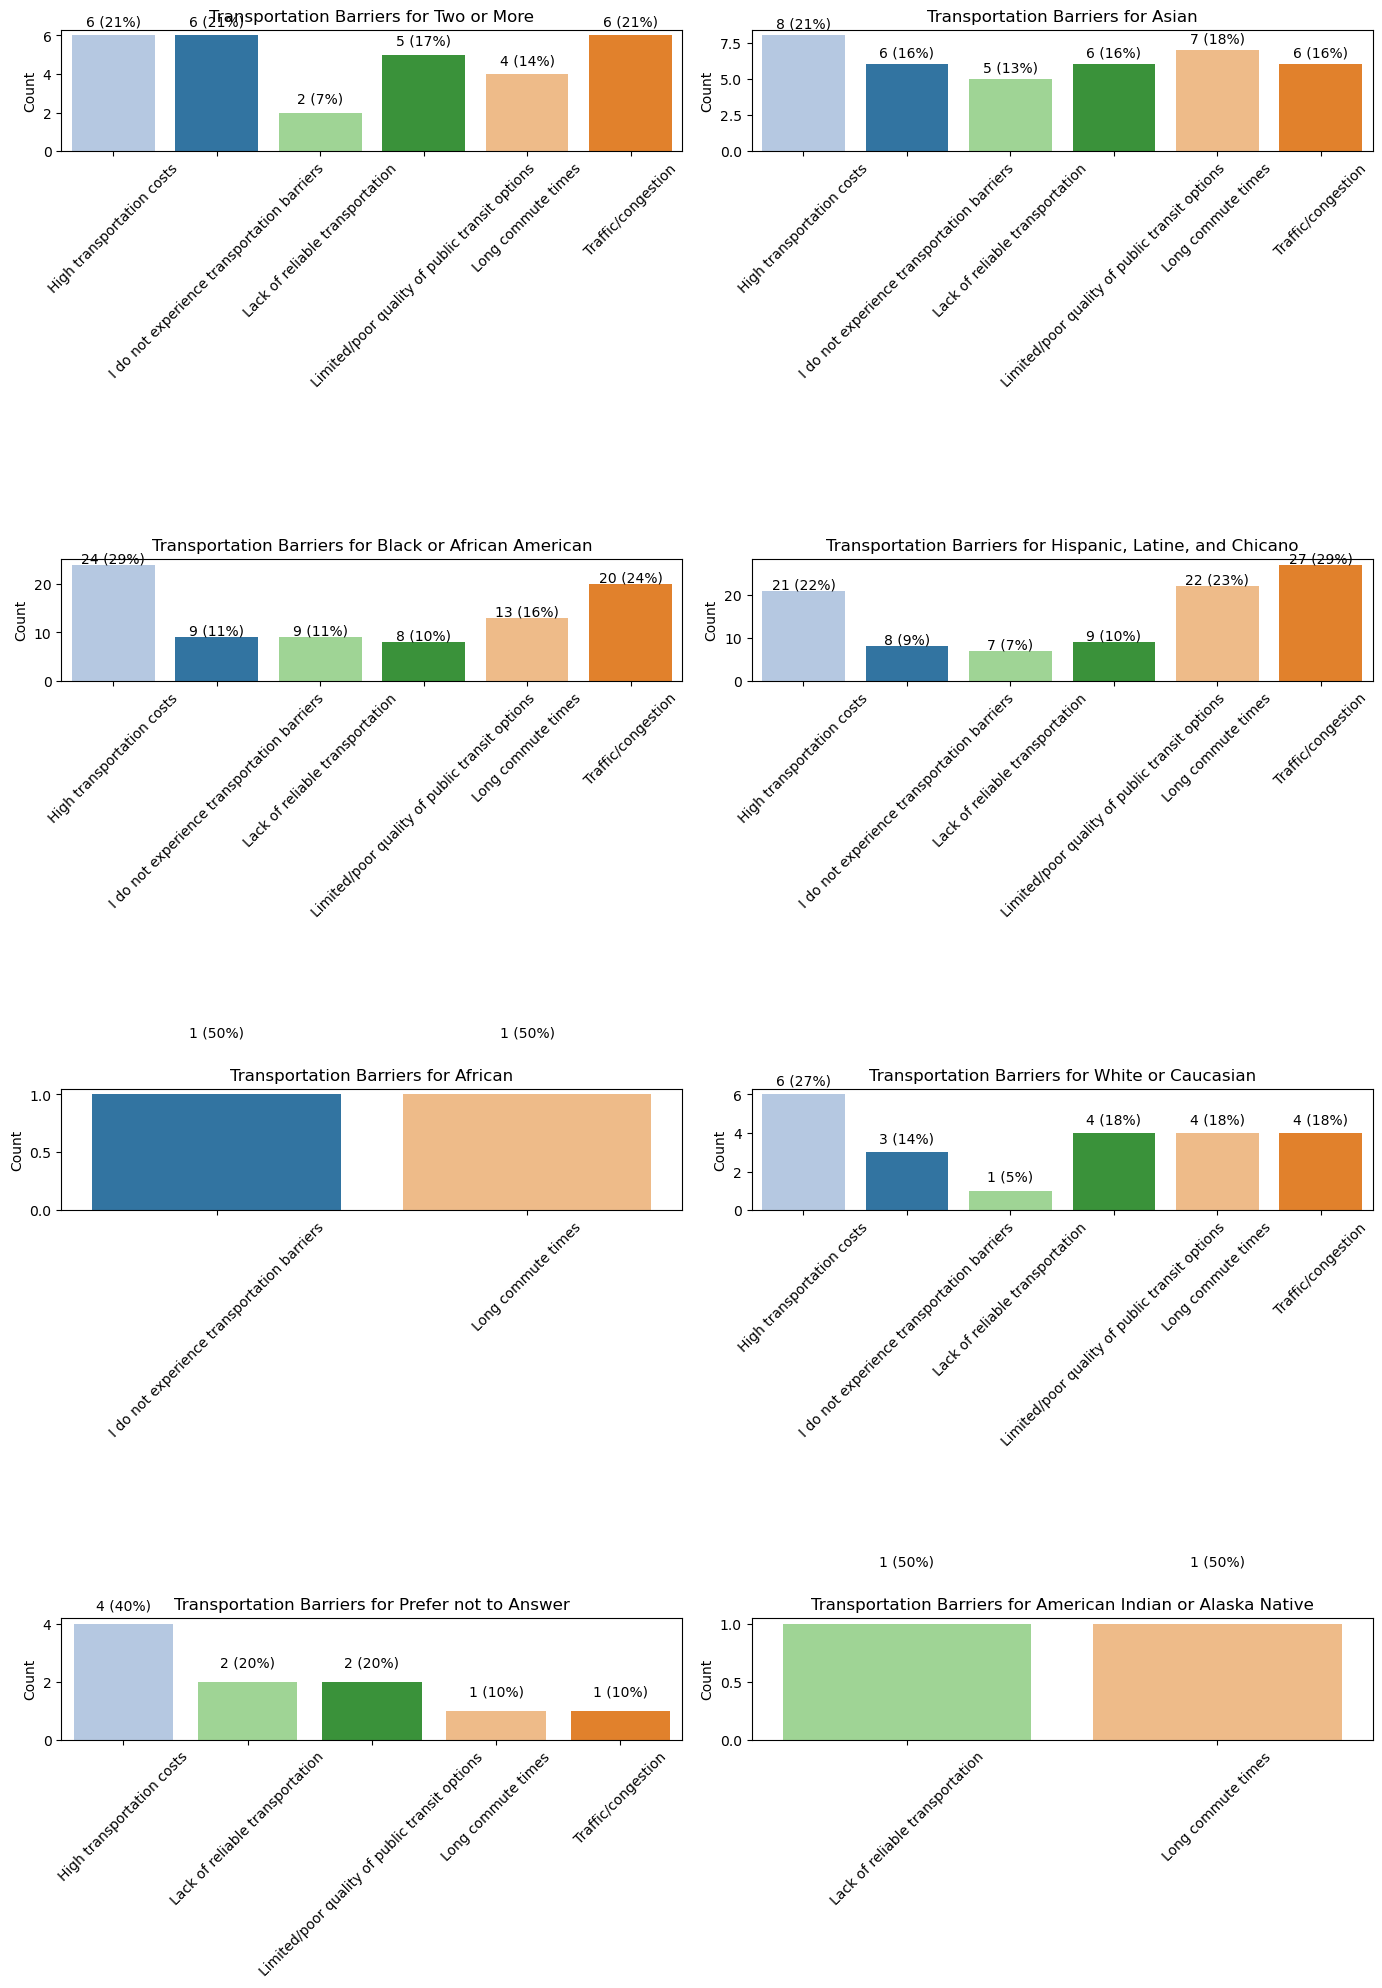

In [ ]:

######
# Filter out rows with missing 'Question 3' or 'Question 13'
survey_filtered = survey.dropna(subset=['Question 3', 'Question 13'])

# Get unique races
races = survey_filtered['Question 3'].unique().tolist()

# Get all unique barriers (reasons)
all_reasons = survey_filtered['Question 13'].dropna().str.split(',').explode().str.strip()
all_reasons = all_reasons.replace('Other: (please describe)', 'Other')
unique_reasons = all_reasons.unique().tolist()

# Generate a consistent color palette
color_list = sns.color_palette('tab20', n_colors=len(unique_reasons))
reason_palette = dict(zip(unique_reasons, color_list))

# Set up subplot grid
n_races = len(races)
n_cols = 2  # Change to 3 if you want more columns
n_rows = math.ceil(n_races / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    # Filter for current race
    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    reasons_series = df_race['Question 13'].str.split(',').explode().str.strip()
    reasons_series = reasons_series.replace('Other: (please describe)', 'Other')

    # Count occurrences
    reason_counts = reasons_series.value_counts().reset_index()
    reason_counts.columns = ['Reason', 'Count']
    reason_counts = reason_counts.groupby('Reason', as_index=False)['Count'].sum()

    total = reason_counts['Count'].sum()

    # Plot
    sns.barplot(x='Reason', y='Count', data=reason_counts, palette=reason_palette, ax=ax)

    # Add labels
    for p in ax.patches:
        height = int(round(p.get_height()))
        percent = int(round((height / total) * 100)) if total > 0 else 0
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5, f'{height} ({percent}%)', ha='center')

    ax.set_title(f'Transportation Barriers for {race}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


High Transportation Costs and Traffic/Congestion were cited as a barrier among students of almost all races. Interestingly, most follow the general trend across all races/ethnicites:

 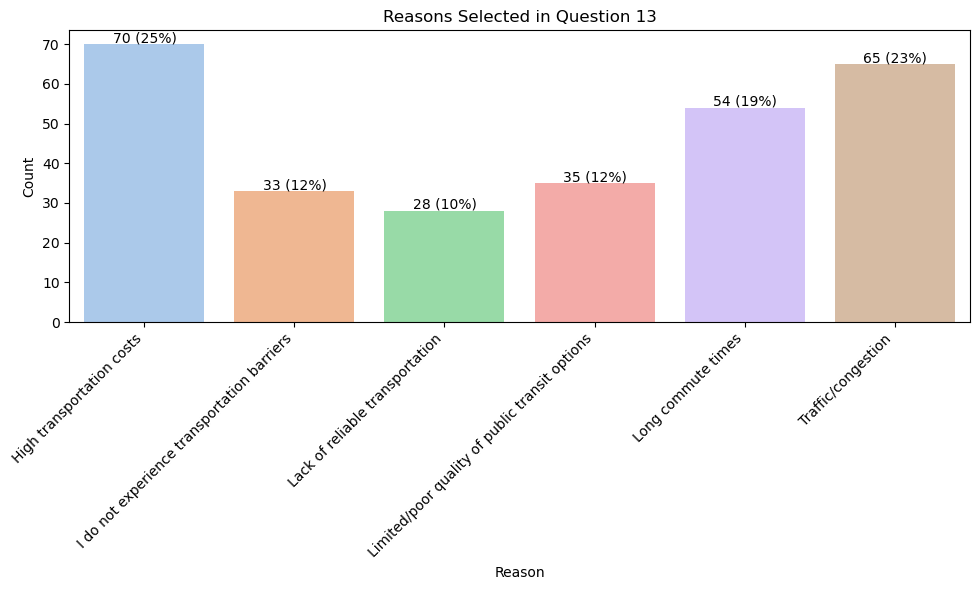


Ok now lets look at race and connections to class postponement due to transportation issues.




**Race/Ethnicity and Primary Community College**

C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3637958255.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3637958255.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3637958255.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\3637958255.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

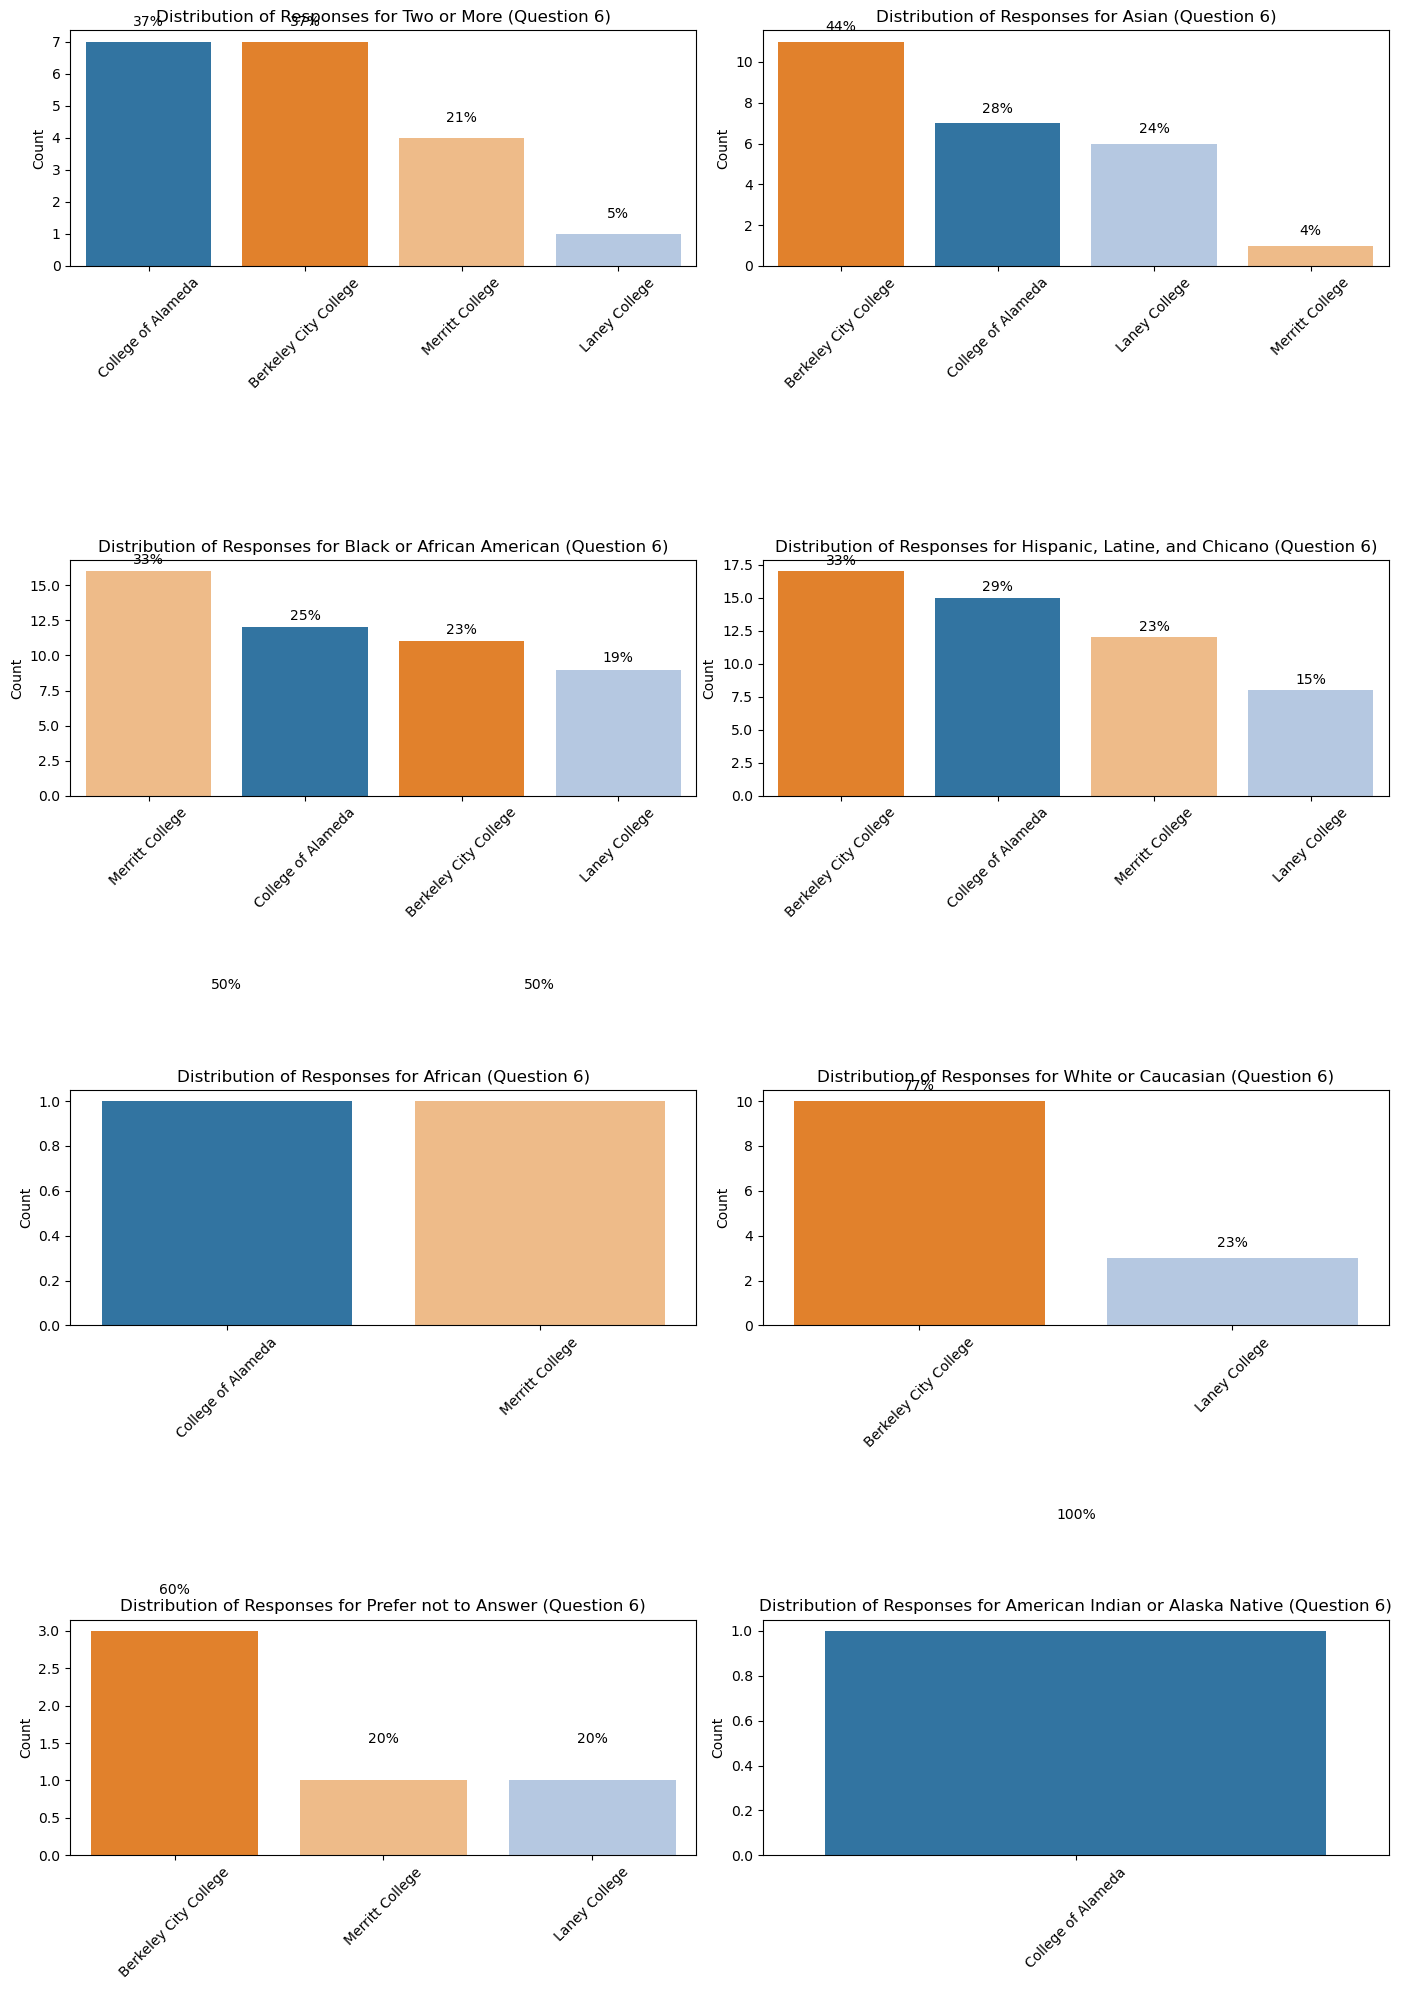

165

In [ ]:
#Question 6 : Primary Community College



# Filter rows with both race and Q6 responses
survey_filtered = survey.dropna(subset=['Question 3', 'Question 6'])

# Unique races
races = survey_filtered['Question 3'].unique().tolist()

# Consistent color palette for Question 6 responses
unique_responses_q6 = survey_filtered['Question 6'].unique().tolist()
color_list = sns.color_palette('tab20', n_colors=len(unique_responses_q6))
response_palette = dict(zip(unique_responses_q6, color_list))

# Set up subplot grid
n_races = len(races)
n_cols = 2  # or 3
n_rows = math.ceil(n_races / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    value_counts = df_race['Question 6'].value_counts()
    percentage = (value_counts / value_counts.sum()) * 100

    stats = value_counts.reset_index()
    stats.columns = ['Response', 'Count']
    stats['Percentage'] = percentage.values

    sns.barplot(
        x='Response',
        y='Count',
        data=stats,
        palette=response_palette,
        ax=ax
    )

    for p, percent in zip(ax.patches, stats['Percentage']):
        height = int(round(p.get_height()))
        percent_label = int(round(percent))
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{percent_label}%',
            ha='center'
        )

    ax.set_title(f'Distribution of Responses for {race} (Question 6)')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()



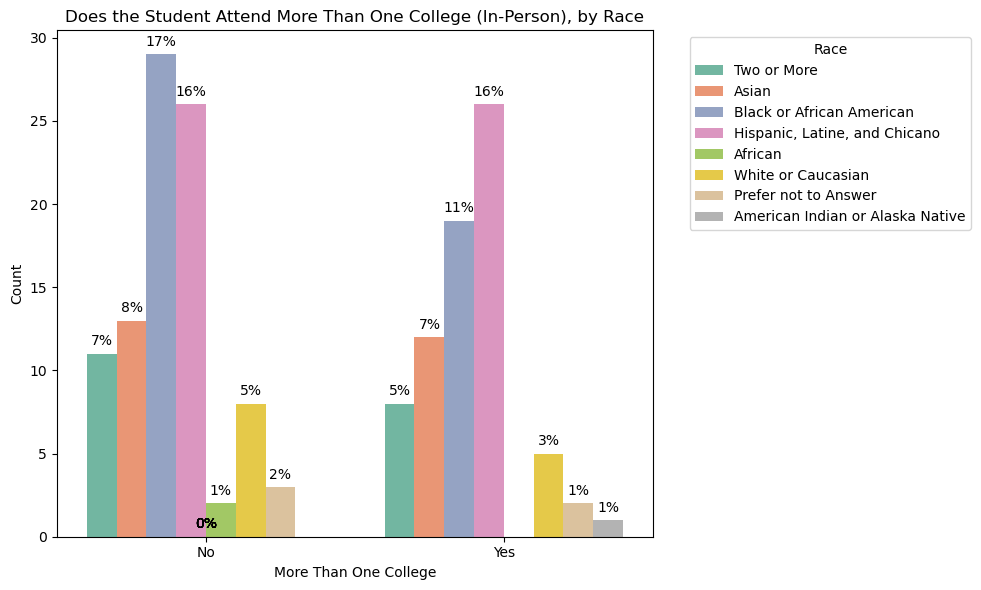

In [ ]:
# Question 7: Other College besides Primary

#Make a new column to determine if the student goes to more than one college
survey['More Than One College'] = survey.apply(
    lambda row: 'No' if (
        pd.isna(row['Question 7']) or
        (row['Question 6'] == row['Question 7']) or
        (isinstance(row['Question 7'], str) and row['Question 7'].startswith(('I do not', 'I take online')))
    ) else 'Yes',
    axis=1
)

# Calculate total number of responses for percentage labels
total = len(survey)

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=survey,
    x='More Than One College',
    hue='Question 3',  # This will color bars by race
    palette='Set2'     # You can choose another palette or define your own
)

# Add percentage labels on top of each bar, formatted without decimals
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{percentage:.0f}%',  # No decimals as per your preference[6]
        ha='center'
    )

plt.title('Does the Student Attend More Than One College (In-Person), by Race')
plt.xlabel('More Than One College')
plt.ylabel('Count')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()











**Race and Connections to Class Postponement**

C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1233289006.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_filtered['Question 14'] = survey_filtered['Question 14'].replace('Other: (please describe)', 'Other')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1233289006.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1233289006.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)
C:\Users\jcoll\AppData\Local\Temp\ipyke

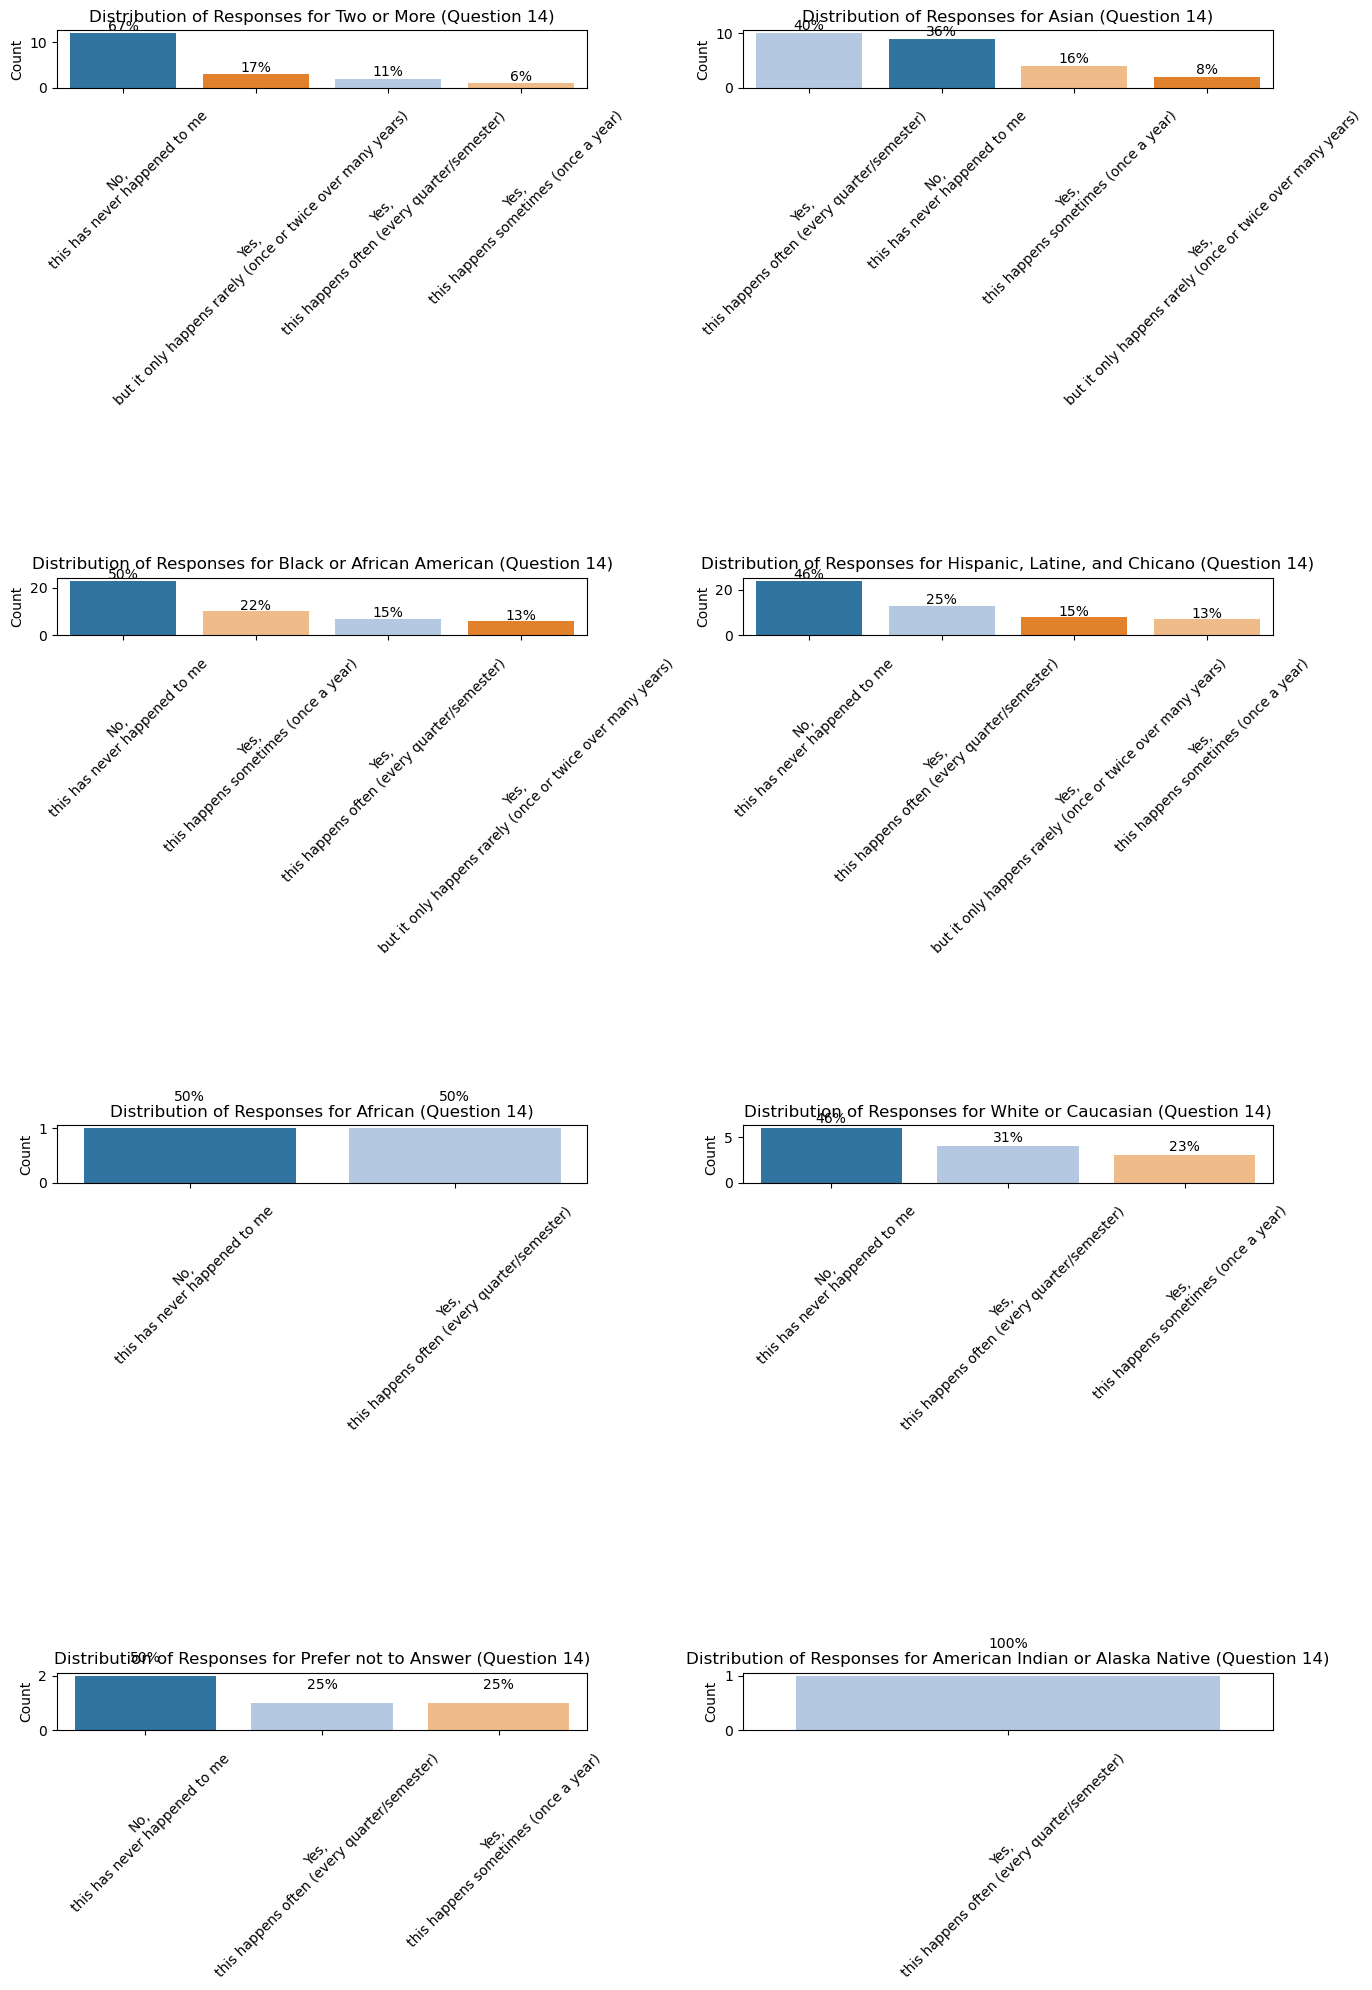

In [ ]:
# Question 14 : Class Postponement

# Filter out rows with missing values in Question 3 or 14
survey_filtered = survey.dropna(subset=['Question 3', 'Question 14'])

# Standardize 'Other: (please describe)' to 'Other'
survey_filtered['Question 14'] = survey_filtered['Question 14'].replace('Other: (please describe)', 'Other')

# Get unique responses and create a consistent color palette
unique_responses_q14 = survey_filtered['Question 14'].unique().tolist()
color_list = sns.color_palette('tab20', n_colors=len(unique_responses_q14))
response_palette = dict(zip(unique_responses_q14, color_list))

# Get unique races
races = survey_filtered['Question 3'].unique().tolist()

# Set up subplot grid
n_races = len(races)
n_cols = 2  # or change to 3 if preferred
n_rows = math.ceil(n_races / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    responses = df_race['Question 14']
    value_counts = responses.value_counts()
    percentage = (value_counts / value_counts.sum()) * 100

    stats = value_counts.reset_index()
    stats.columns = ['Response', 'Count']
    stats['Percentage'] = percentage.values

    sns.barplot(
        x='Response',
        y='Count',
        data=stats,
        palette=response_palette,
        ax=ax
    )

    for p, percent in zip(ax.patches, stats['Percentage']):
        height = int(round(p.get_height()))
        percent_label = int(round(percent))
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{percent_label}%',
            ha='center'
        )

    ax.set_title(f'Distribution of Responses for {race} (Question 14)')
    ax.set_xlabel('')
    # Manually break long labels into two lines
    new_labels = [label.get_text().replace(' ', '\n', 1) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Remove unused axes
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])



plt.tight_layout()
plt.show()




C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\4107510858.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_filtered['Question 14'] = survey_filtered['Question 14'].replace('Other: (please describe)', 'Other')


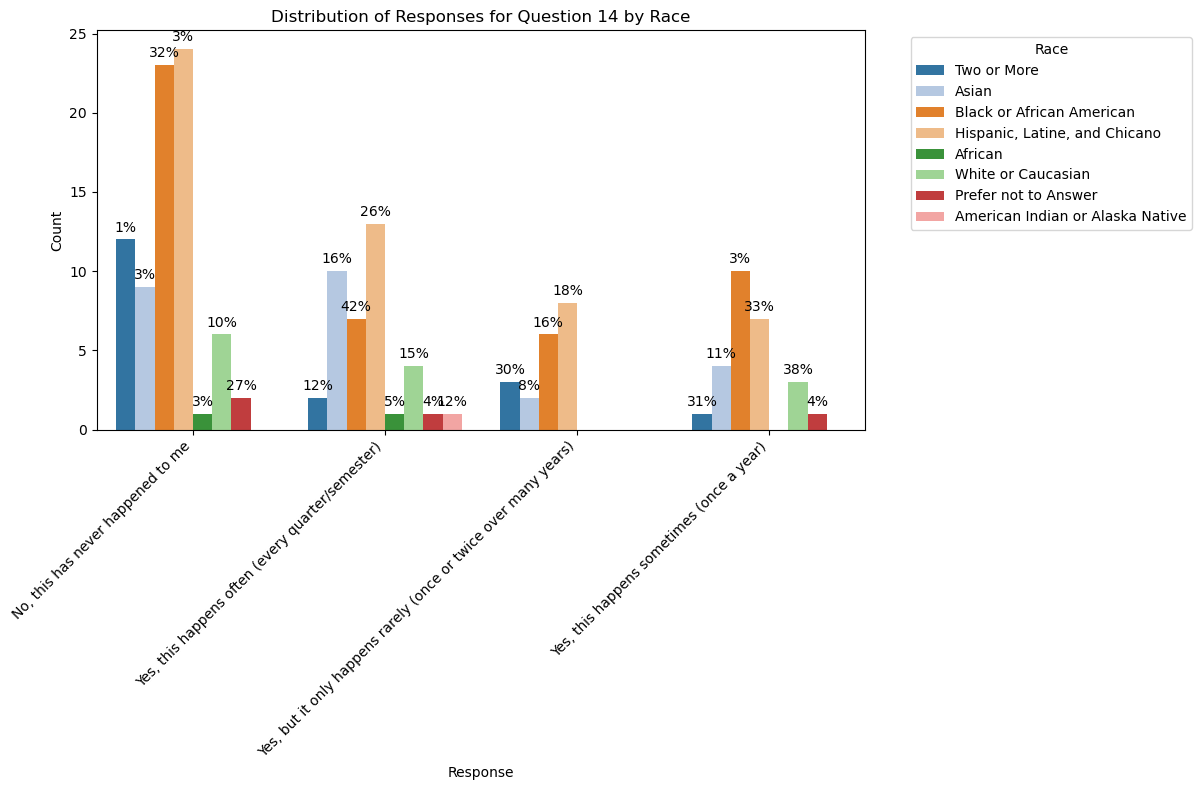

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter out rows with missing 'Question 3' or 'Question 14'
survey_filtered = survey.dropna(subset=['Question 3', 'Question 14'])

# Standardize 'Other: (please describe)' to 'Other' in 'Question 14'
survey_filtered['Question 14'] = survey_filtered['Question 14'].replace('Other: (please describe)', 'Other')

# Get all unique responses from Question 14 for consistent coloring
unique_responses_q14 = survey_filtered['Question 14'].unique().tolist()
color_list = sns.color_palette('tab20', n_colors=len(unique_responses_q14))
response_palette = dict(zip(unique_responses_q14, color_list))

# Create a combined bar plot for all races on one graph
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=survey_filtered,
    x='Question 14',
    hue='Question 3',  # Each race will be a different color
    palette='tab20'    # You can use another palette if you prefer
)

# Calculate total counts per response for percentage labels
response_counts = survey_filtered.groupby(['Question 14', 'Question 3']).size().reset_index(name='Count')
total_counts = survey_filtered.groupby('Question 14').size().reset_index(name='Total')
merged_counts = pd.merge(response_counts, total_counts, on='Question 14')

# Add percentage labels on top of each bar, rounded to whole numbers
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if i < len(merged_counts):
        count = merged_counts.iloc[i]['Count']
        total = merged_counts.iloc[i]['Total']
        percentage = (count / total) * 100
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{int(round(percentage))}%',
            ha='center'
        )

plt.title('Distribution of Responses for Question 14 by Race')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Trends seem to be consistent across races, with 50% of students of almost every race/ethnicity experiencing some form of class postponement due to percieved transportation impacts on their academic success.

**Looking at Race/Ethnicity and reasons for choice of Major**

C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\498043763.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\498043763.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\498043763.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\498043763.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(n

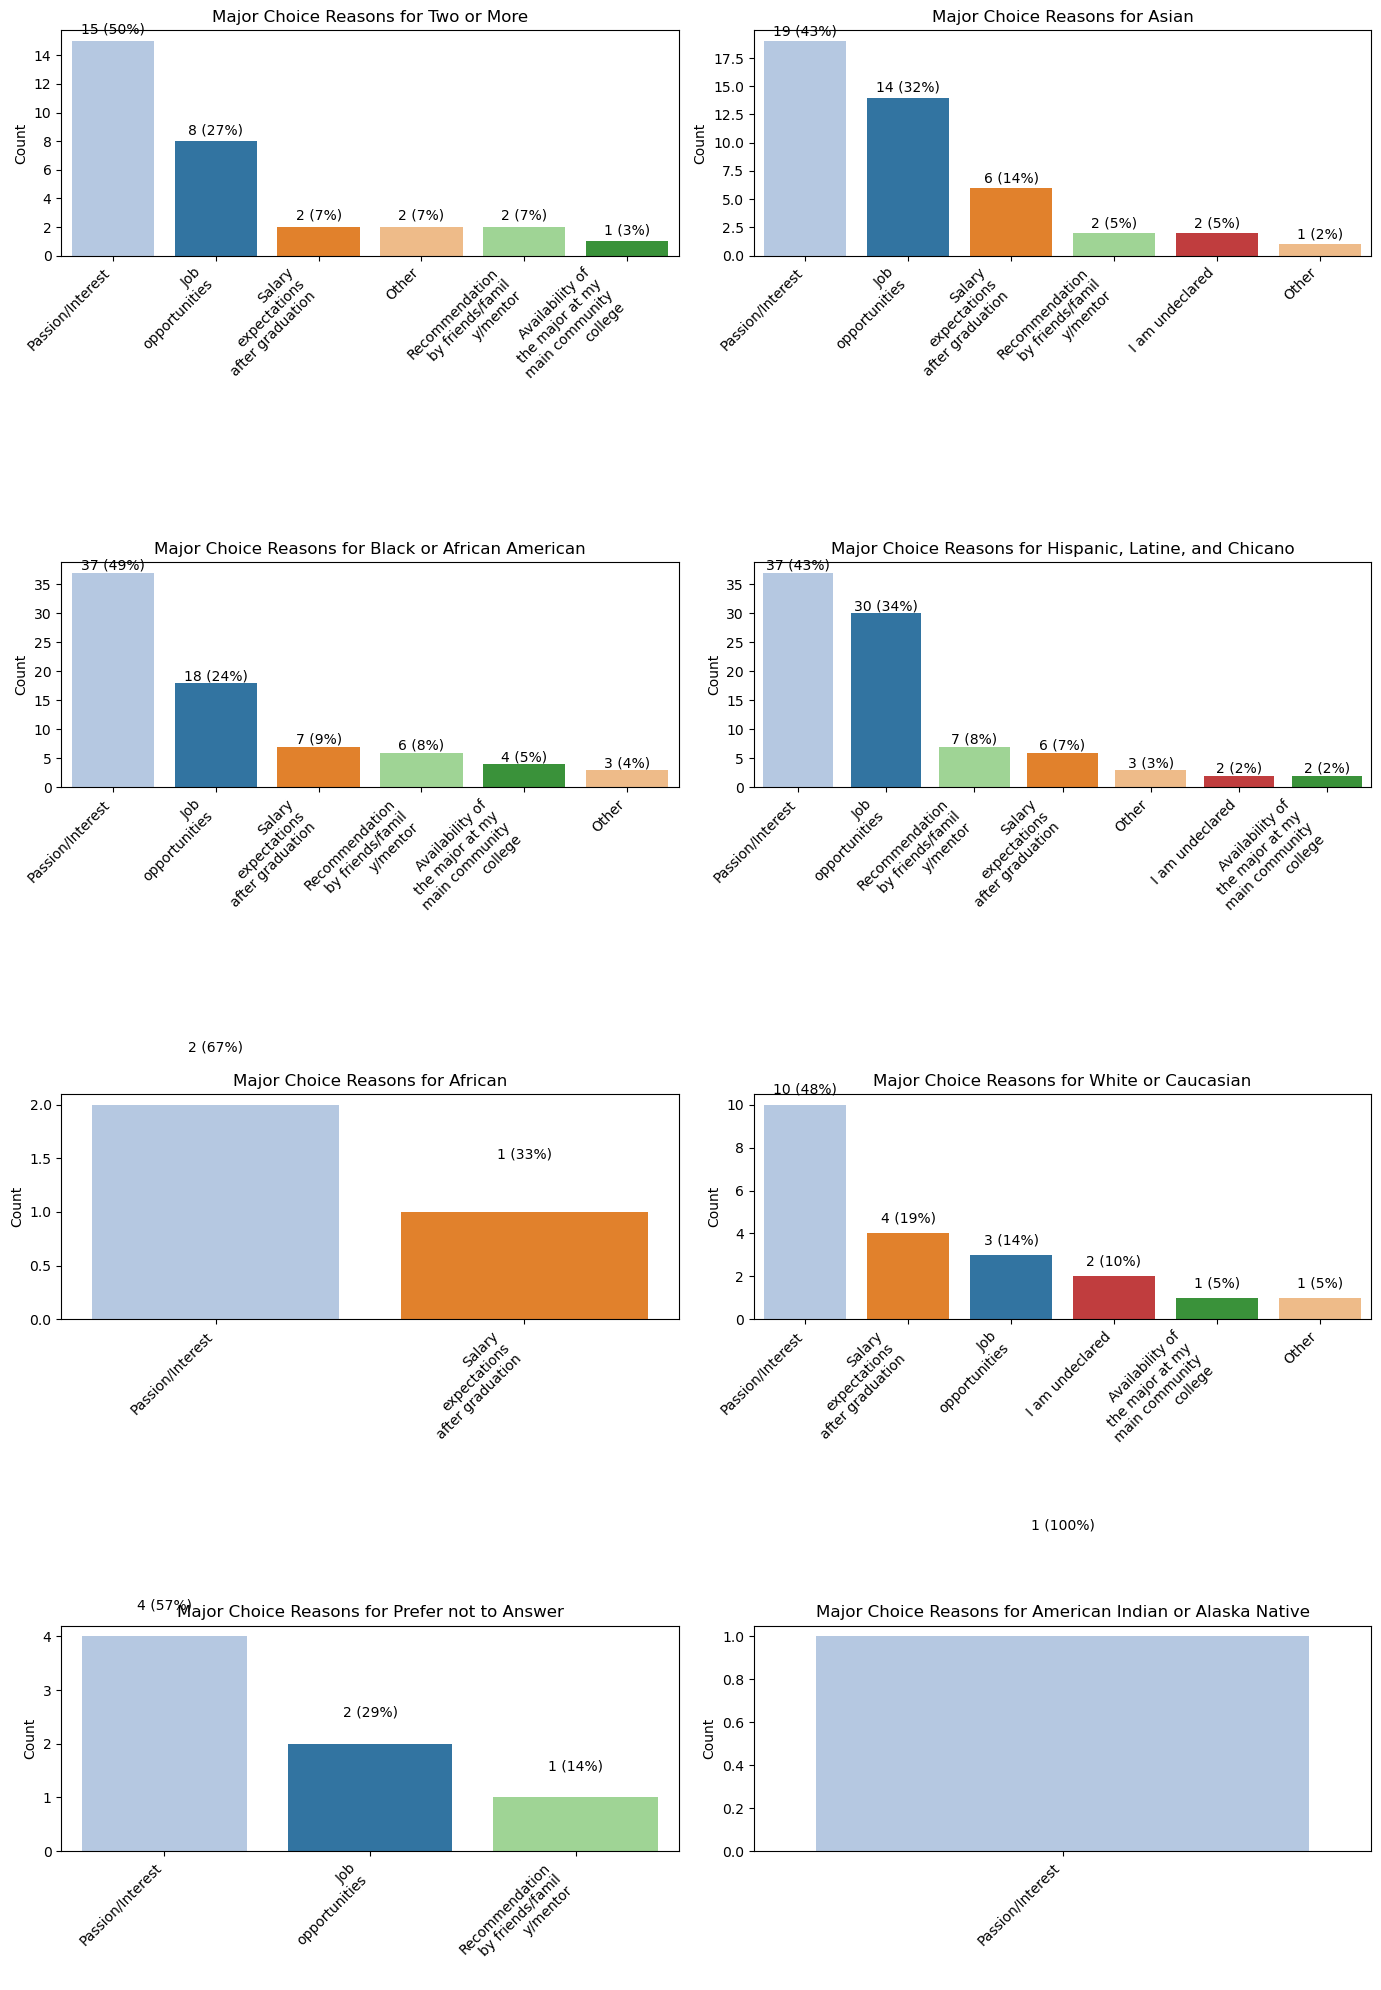

In [ ]:
# Question 10: Reason for Choice of Major

import textwrap

# Wrap labels helper function
def wrap_label(text, width=15):
    return "\n".join(textwrap.wrap(text, width))

# Filter out rows with missing 'Question 3' or 'Question 10' 
survey_filtered = survey.dropna(subset=['Question 3', 'Question 10'])

# Split, explode, and clean up the reasons in Question 10
reasons_series_q10 = survey_filtered['Question 10'].str.split(',').explode().str.strip()
reasons_series_q10 = reasons_series_q10.replace('Other: (please describe)', 'Other')

# Align race with each exploded reason
survey_filtered_expanded = survey_filtered.loc[reasons_series_q10.index, ['Question 3']].copy()
survey_filtered_expanded['Reason'] = reasons_series_q10

# Get all unique reasons for consistent coloring
unique_reasons_q10 = survey_filtered_expanded['Reason'].unique().tolist()
color_list = sns.color_palette('tab20', n_colors=len(unique_reasons_q10))
reason_palette = dict(zip(unique_reasons_q10, color_list))

# Get unique races
races = survey_filtered_expanded['Question 3'].unique().tolist()

# Set up subplot grid
n_races = len(races)
n_cols = 2
n_rows = math.ceil(n_races / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    df_race = survey_filtered_expanded[survey_filtered_expanded['Question 3'] == race]
    reason_counts = df_race['Reason'].value_counts().reset_index()
    reason_counts.columns = ['Reason', 'Count']
    total = reason_counts['Count'].sum()

    sns.barplot(
        x='Reason',
        y='Count',
        data=reason_counts,
        palette=reason_palette,
        ax=ax
    )

    # Add count and percentage labels
    for p, count in zip(ax.patches, reason_counts['Count']):
        height = int(round(p.get_height()))
        percent = int(round((height / total) * 100)) if total > 0 else 0
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{height} ({percent}%)',
            ha='center'
        )

    # Wrap and rotate x-axis labels
    new_labels = [wrap_label(label.get_text(), width=16) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    ax.set_title(f'Major Choice Reasons for {race}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Remove unused axes
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()



Trends are very consistent across races/ethnicities

**Looking at Race/Ethnicity and reason for choice of College**

C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1914191010.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1914191010.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1914191010.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1914191010.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabe

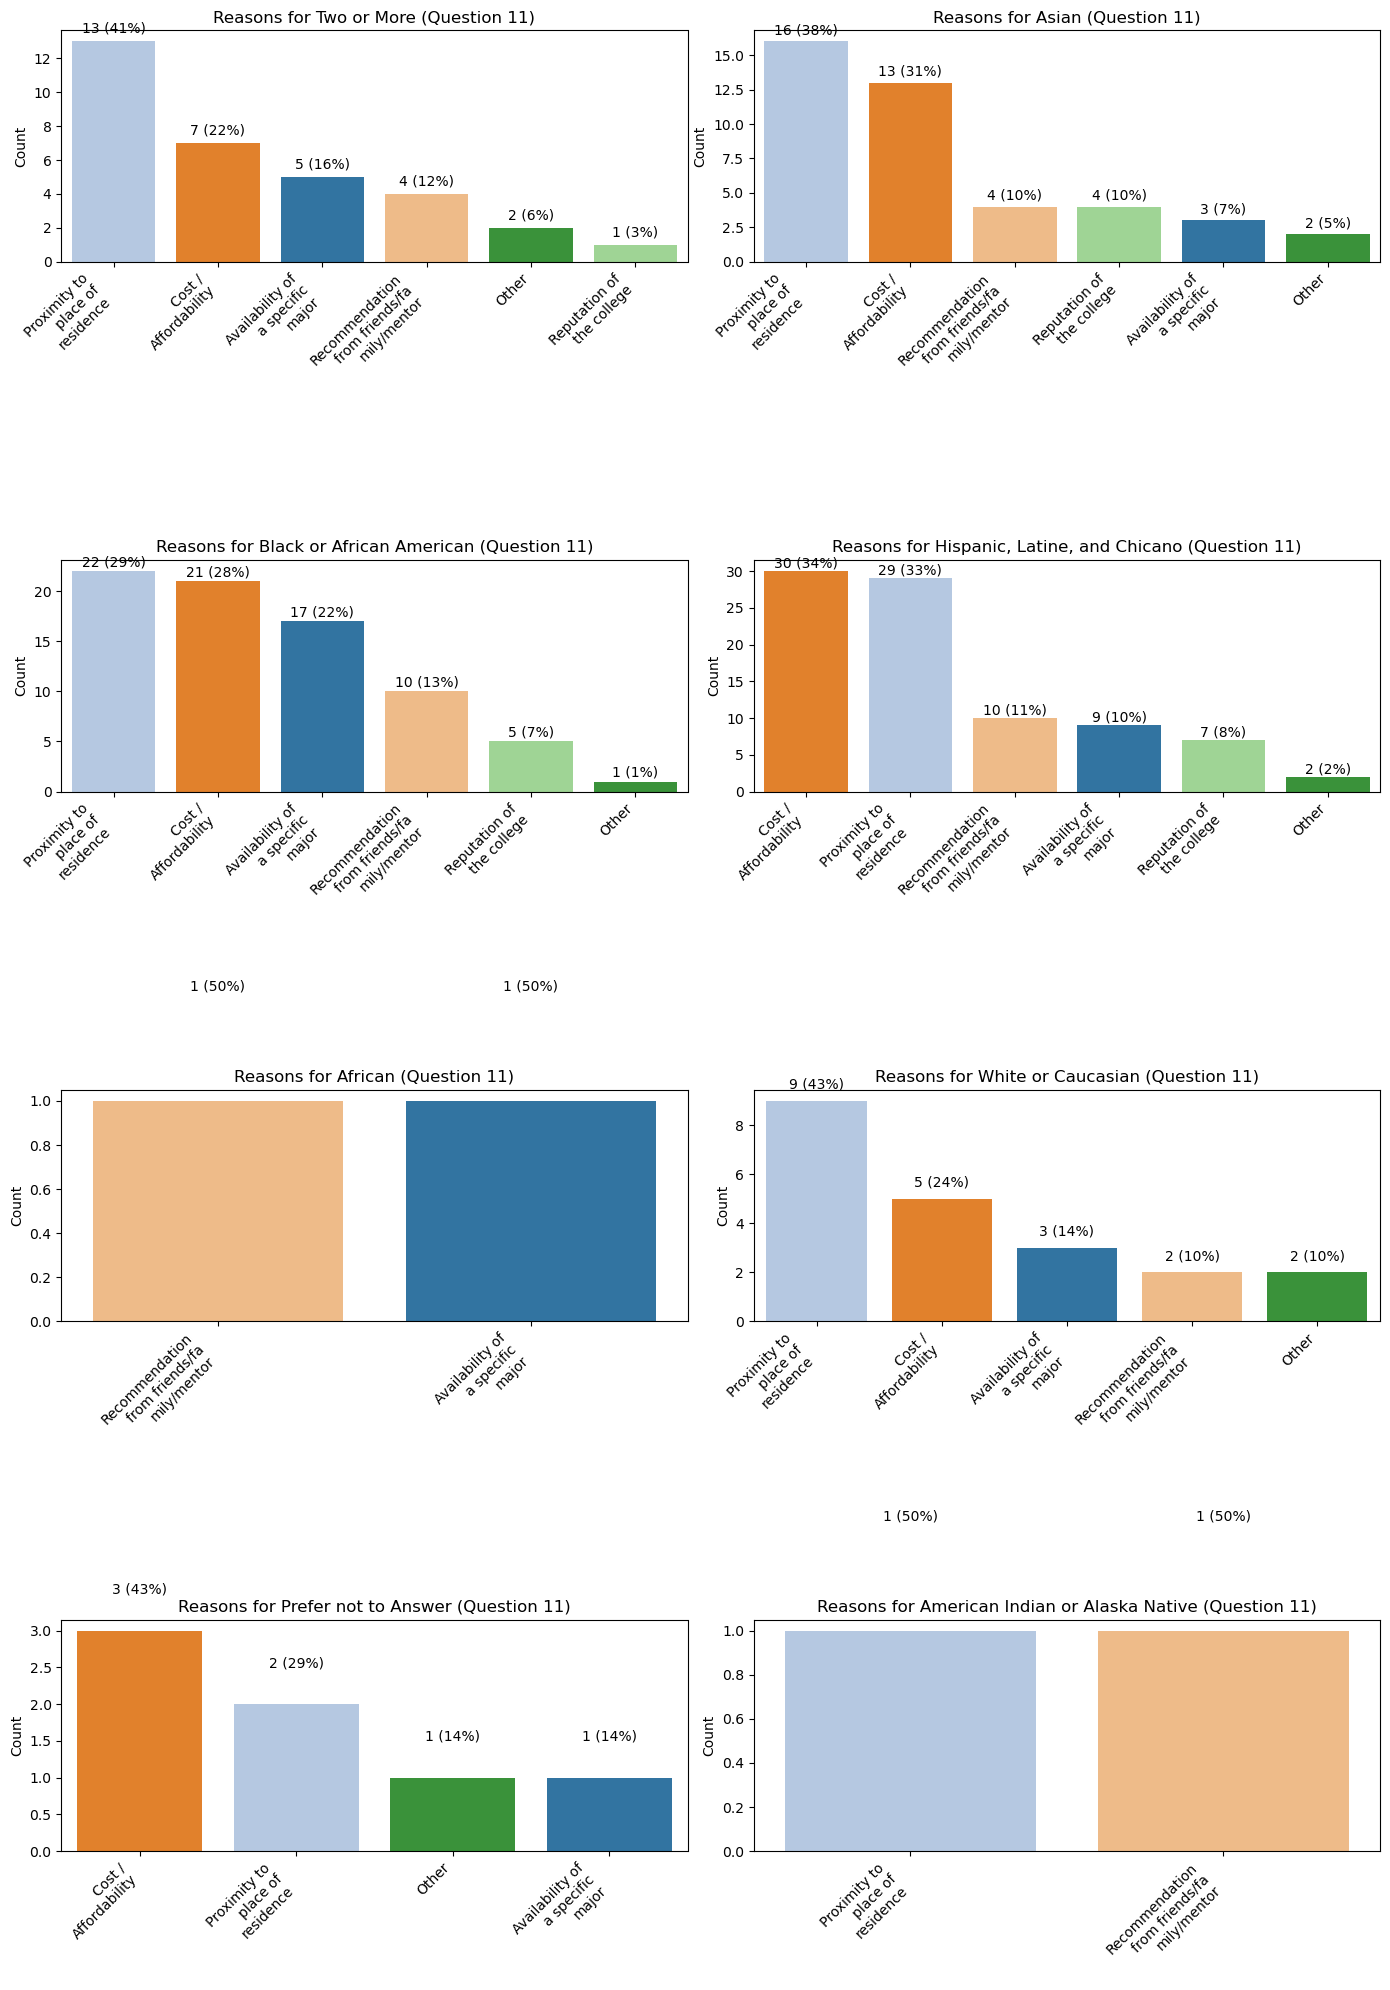

In [ ]:
# Question 11: Reason for Choice of College


# Helper to wrap long labels
def wrap_label(text, width=15):
    return "\n".join(textwrap.wrap(text, width))

# Filter out rows with missing 'Question 3' or 'Question 11'
survey_filtered = survey.dropna(subset=['Question 3', 'Question 11'])

# Split, explode, and clean up the reasons in Question 11
reasons_series_q11 = survey_filtered['Question 11'].str.split(',').explode().str.strip()
reasons_series_q11 = reasons_series_q11.replace('Other: (please describe)', 'Other')

# Align race with each exploded reason
survey_filtered_expanded = survey_filtered.loc[reasons_series_q11.index, ['Question 3']].copy()
survey_filtered_expanded['Reason'] = reasons_series_q11

# Get all unique reasons for consistent coloring
unique_reasons_q11 = survey_filtered_expanded['Reason'].unique().tolist()
color_list = sns.color_palette('tab20', n_colors=len(unique_reasons_q11))
reason_palette = dict(zip(unique_reasons_q11, color_list))

# Get unique races
races = survey_filtered_expanded['Question 3'].unique().tolist()

# Set up subplot grid
n_races = len(races)
n_cols = 2  # or change to 3 depending on how many panels you want per row
n_rows = math.ceil(n_races / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    df_race = survey_filtered_expanded[survey_filtered_expanded['Question 3'] == race]
    reason_counts = df_race['Reason'].value_counts().reset_index()
    reason_counts.columns = ['Reason', 'Count']
    total = reason_counts['Count'].sum()

    sns.barplot(
        x='Reason',
        y='Count',
        data=reason_counts,
        palette=reason_palette,
        ax=ax
    )

    # Add count and percent labels
    for p, count in zip(ax.patches, reason_counts['Count']):
        height = int(round(p.get_height()))
        percent = int(round((height / total) * 100)) if total > 0 else 0
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{height} ({percent}%)',
            ha='center'
        )

    # Wrap and rotate x-axis labels
    new_labels = [wrap_label(label.get_text(), width=15) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    ax.set_title(f'Reasons for {race} (Question 11)')
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Remove any unused subplot panels
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()

Interesting, Latine/Hispanic-identifying individuals tend to prioritize cost over proximity, but proximity to residence remains the primary factor for attending a particular college for most races/ethnicities.

**Race and Primary Mode to Community College**

C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1805500519.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1805500519.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1805500519.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\1805500519.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabe

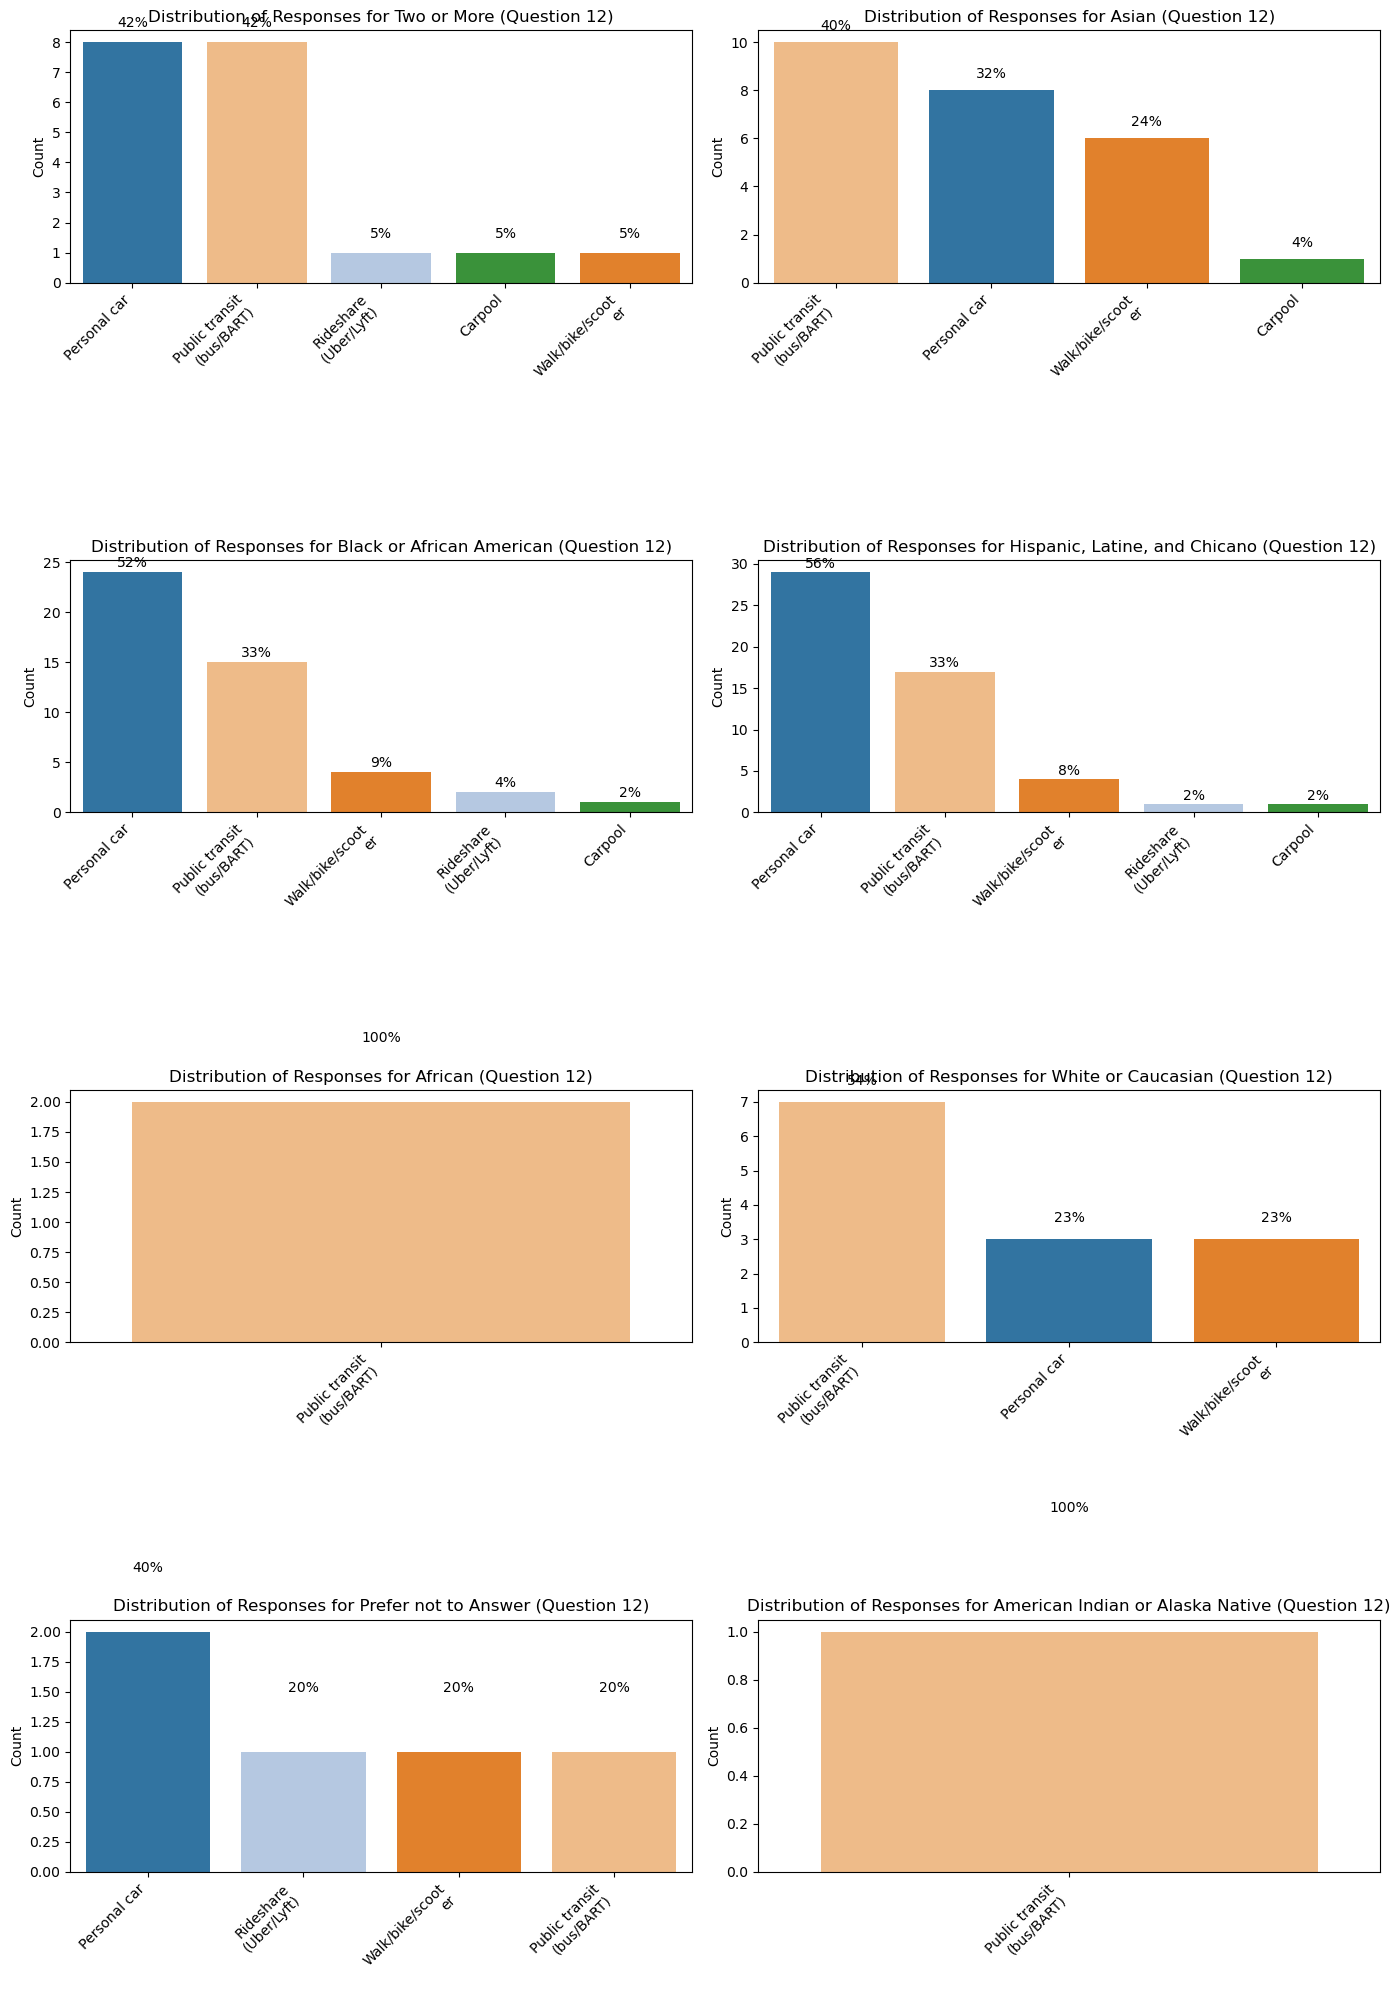

In [ ]:
# Question 12: Mode of Transportation

# Helper to wrap long x-axis labels
def wrap_label(text, width=15):
    return "\n".join(textwrap.wrap(text, width))

# Filter out rows with missing 'Question 3' or 'Question 12'
survey_filtered = survey.dropna(subset=['Question 3', 'Question 12'])

# Get all unique responses from Question 12 for consistent coloring
unique_responses_q12 = survey_filtered['Question 12'].unique().tolist()
color_list = sns.color_palette('tab20', n_colors=len(unique_responses_q12))
response_palette = dict(zip(unique_responses_q12, color_list))

# Get unique races
races = survey_filtered['Question 3'].unique().tolist()

# Set up subplot grid
n_races = len(races)
n_cols = 2  # or change to 3 if you prefer
n_rows = math.ceil(n_races / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows), squeeze=False)

for idx, race in enumerate(races):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    df_race = survey_filtered[survey_filtered['Question 3'] == race]
    value_counts = df_race['Question 12'].value_counts()
    percentage = (value_counts / value_counts.sum()) * 100

    stats = value_counts.reset_index()
    stats.columns = ['Response', 'Count']
    stats['Percentage'] = percentage.values

    sns.barplot(
        x='Response',
        y='Count',
        data=stats,
        palette=response_palette,
        ax=ax
    )

    # Add percentage labels on top of each bar
    for p, percent in zip(ax.patches, stats['Percentage']):
        height = int(round(p.get_height()))
        percent_label = int(round(percent))
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{percent_label}%',
            ha='center'
        )

    # Wrap and rotate x-axis labels
    new_labels = [wrap_label(label.get_text(), width=15) for label in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    ax.set_title(f'Distribution of Responses for {race} (Question 12)')
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Remove any unused subplot panels
for i in range(n_races, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

plt.tight_layout()
plt.show()


Interestingly, Asian and Caucasion/White identifying individuals have a higher split of public transit use while Black/African American and Hispanic/Latine individuals have a higher split of personal-car usership as far as trips to school.

C:\Users\jcoll\AppData\Local\Temp\ipykernel_33272\2276653076.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


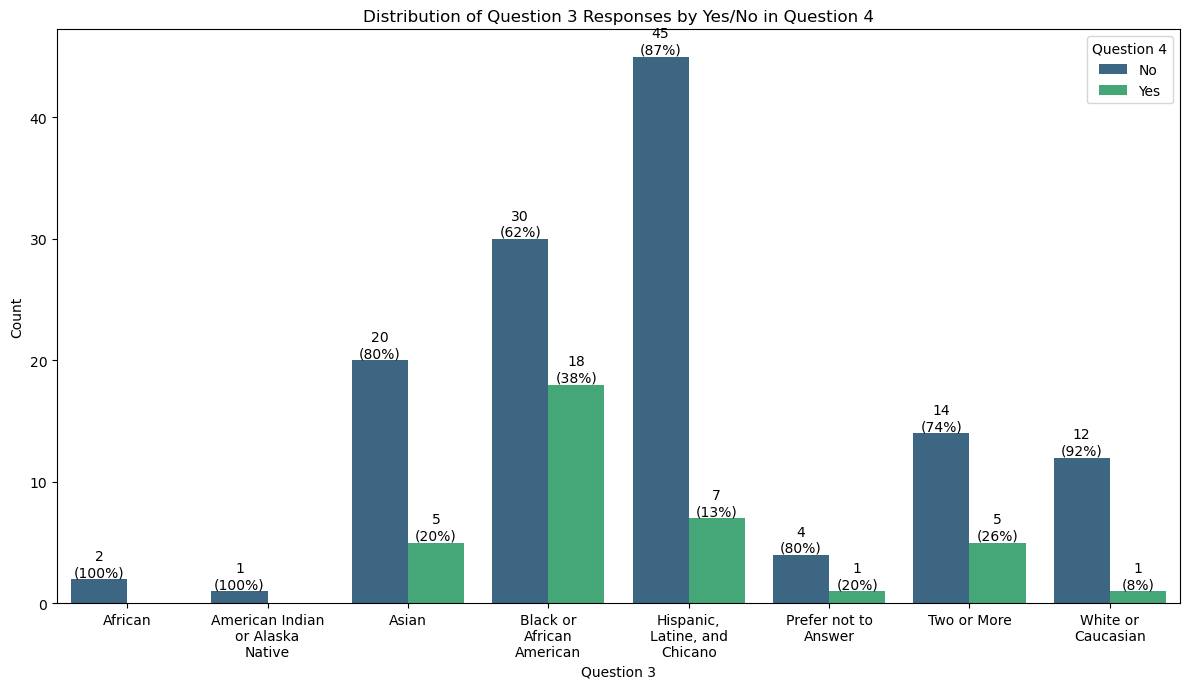

In [ ]:
# Question 4 : Caregiver status

# Lets see how caregiver status breaks down by race/ethnicity

import textwrap

# Count occurrences of each combination of Question 3 and Question 4
count_df = survey.groupby(['Question 3', 'Question 4']).size().reset_index(name='Count')

# Calculate percentages within each Question 3 group
count_df['Percentage'] = count_df.groupby('Question 3')['Count'].transform(lambda x: (x / x.sum() * 100).round(0).astype(int))

# Plotting
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Question 3', y='Count', hue='Question 4', data=count_df, palette='viridis')

# Function to wrap labels
def wrap_labels(ax, width=15):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        wrapped = '\n'.join(textwrap.wrap(text, width=width))
        labels.append(wrapped)
    ax.set_xticklabels(labels, rotation=0)

# Add count and percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2.
        # Find the corresponding row in count_df
        xticks = [lbl.get_text().replace('\n', ' ') for lbl in ax.get_xticklabels()]
        idx = int(round(p.get_x() + p.get_width() / 2))
        if idx < len(xticks):
            resp = xticks[idx]
            row = count_df[(count_df['Question 3'] == resp) & (count_df['Count'] == height)]
            percent = row['Percentage'].values[0] if not row.empty else 0
            ax.annotate(f'{int(height)}\n({percent}%)', (x, height), ha='center', va='bottom', fontsize=10)

wrap_labels(ax, width=15)

plt.title('Distribution of Question 3 Responses by Yes/No in Question 4')
plt.ylabel('Count')
plt.xlabel('Question 3')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assume your DataFrame is named 'survey' and has columns 'Race' and 'Caregiver' (Yes/No)
contingency = pd.crosstab(survey['Question 3'], survey['Question 4'])

chi2, p, dof, expected = chi2_contingency(contingency)

print('Chi-square statistic:', chi2)
print('p-value:', p)
print('Degrees of freedom:', dof)
print('\nObserved counts:\n', contingency)
print('\nExpected counts:\n', pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))

if p < 0.05:
    print("\nThere is a statistically significant association between race and caregiver status.")
else:
    print("\nThere is NOT a statistically significant association between race and caregiver status." \
    "*p-value of 0.36 is greater than 0.05 (for a 95% Confidence Interval)")


Chi-square statistic: 11.428352219881825
p-value: 0.12099521727359136
Degrees of freedom: 7

Observed counts:
 Question 4                        No  Yes
Question 3                               
African                            2    0
American Indian or Alaska Native   1    0
Asian                             20    5
Black or African American         30   18
Hispanic, Latine, and Chicano     45    7
Prefer not to Answer               4    1
Two or More                       14    5
White or Caucasian                12    1

Expected counts:
 Question 4                               No        Yes
Question 3                                            
African                            1.551515   0.448485
American Indian or Alaska Native   0.775758   0.224242
Asian                             19.393939   5.606061
Black or African American         37.236364  10.763636
Hispanic, Latine, and Chicano     40.339394  11.660606
Prefer not to Answer               3.878788   1.121212
Two or Mor